In [1]:
# Common
import keras
import numpy as np
import pandas as pd
import tensorflow as tf

# Data
from tensorflow.image import resize
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Data Viz
import seaborn as sns
import matplotlib.pyplot as plt

# Model
from keras.layers import LSTM, Dense, Dropout
from keras import Sequential

# Callbacks 
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Model Performance
from sklearn.metrics import mean_squared_error

# Data preprocess
from sklearn.preprocessing import MinMaxScaler

# Model Viz
from tensorflow.keras.utils import plot_model

import os

2023-03-02 10:46:26.985529: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#getting the data
data = pd.read_csv (r'./tesla.csv')

In [3]:
data.head()  #open represents the price at the beginning of the day /close for the end
                #high represents the highest price for a given day and vis versa for low
                #volume represents the amount of stocks sold for a day
                #ajd close represents the modified closing price based on corporate actions(like dividends..)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
1,2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
2,2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
3,2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500
4,2010-07-07,1.093333,1.108667,0.998667,1.053333,1.053333,103825500


In [4]:
len(data)

3077

In [5]:
data = data[['Date', 'Close']] #predictions will be daily.
data.head()

,Date,Close
0,2010-06-30,1.588667
1,2010-07-01,1.464000
2,2010-07-02,1.280000
3,2010-07-06,1.074000
4,2010-07-07,1.053333


In [6]:
data.Date = pd.to_datetime(data.Date, format = '%Y/%m/%d')#converting the date to panda format
plot_data = data.set_index('Date')

<AxesSubplot:xlabel='Date'>

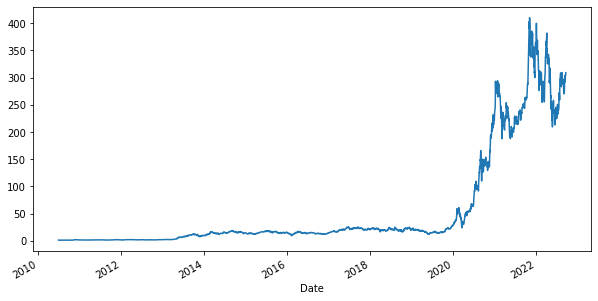

In [7]:
plot_data['Close'].plot(figsize=(10,5)) 

In [8]:
data = data.loc[2600:]

Text(0.5, 0, 'Date')

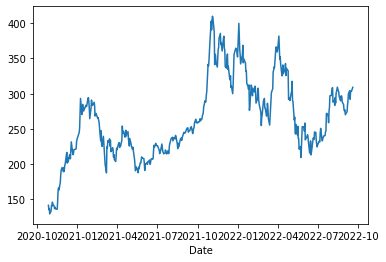

In [15]:
plt.plot(data['Date'], data['Close'])
plt.xlabel('Date')

In [16]:
data = data.drop('Date', axis = 1)
data = data.reset_index(drop = True)
data = data.astype('float32')
data.head()

,Close
0,141.559998
1,135.339996
2,136.943329
3,129.346664
4,133.503326


In [17]:
scaler = MinMaxScaler(feature_range=(0,1))
data = scaler.fit_transform(data) #scaling the data so we get values from 0 to 1
data[:10]

array([[0.04352218],
       [0.02135721],
       [0.02707067],
       [0.        ],
       [0.01481226],
       [0.04259568],
       [0.03912717],
       [0.05945098],
       [0.04978204],
       [0.03945976]], dtype=float32)

In [18]:
train_size = int(len(data)*0.8)
test_size = len(data) - train_size
train_set,test_set = data[:train_size], data[train_size:]

In [19]:
#method to find features for each instances
def features(data, window_size):
    X,Y = [],[]
    for i in range(len(data) - window_size - 1): #for the number of elts of a given data between 0 and the total
                                                 #minus window_size -1 since len is an int not an index
        window = data[i:(i + window_size)]       #the index of elts inside the window
        X.append(window)                         #we append to X the elts whose indexes are inside the window
        Y.append(data[i + window_size])          #and in Y we append the target, i.e the size of the window +
    return np.array(X), np.array(Y)              #i; it returns the arrays of elts and the target.

In [20]:
window_size = 20
X_train, Y_train = features(train_set, window_size)

X_test, Y_test = features(test_set, window_size)

# Reshape to the format of [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [21]:
tf.random.set_seed(11)
np.random.seed(11)

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [34]:
X_train.shape[1]

1

In [22]:
from keras.layers import GRU
model = Sequential()
model.add(GRU(units = 50,activation = 'relu', 
                           return_sequences=True, input_shape = (X_train.shape[1], window_size)))
model.add(Dropout(0.2))

model.add(Dense(1, activation = 'linear'))
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

2023-03-02 10:51:05.420475: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
history = model.fit(X_train, Y_train, epochs = 100, batch_size = 20, 
              validation_data = (X_test, Y_test), shuffle = False)

model.summary()

Epoch 1/100
18/18 [==============================] - 2s 17ms/step - loss: 0.0483 - last_time_step_mse: 0.0483 - val_loss: 0.0051 - val_last_time_step_mse: 0.0054
Epoch 2/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0192 - last_time_step_mse: 0.0192 - val_loss: 0.0050 - val_last_time_step_mse: 0.0048
Epoch 3/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0162 - last_time_step_mse: 0.0162 - val_loss: 0.0039 - val_last_time_step_mse: 0.0038
Epoch 4/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0142 - last_time_step_mse: 0.0142 - val_loss: 0.0034 - val_last_time_step_mse: 0.0033
Epoch 5/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0127 - last_time_step_mse: 0.0127 - val_loss: 0.0030 - val_last_time_step_mse: 0.0030
Epoch 6/100
18/18 [==============================] - 0s 4ms/step - loss: 0.0127 - last_time_step_mse: 0.0127 - val_loss: 0.0042 - val_last_time_step_mse: 0.0041
Epoch 7/100
18/18 [==============

18/18 [==============================] - 0s 3ms/step - loss: 0.0061 - last_time_step_mse: 0.0061 - val_loss: 0.0019 - val_last_time_step_mse: 0.0019
Epoch 52/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0050 - last_time_step_mse: 0.0050 - val_loss: 0.0015 - val_last_time_step_mse: 0.0015
Epoch 53/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0044 - last_time_step_mse: 0.0044 - val_loss: 0.0015 - val_last_time_step_mse: 0.0015
Epoch 54/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0052 - last_time_step_mse: 0.0052 - val_loss: 0.0015 - val_last_time_step_mse: 0.0015
Epoch 55/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0052 - last_time_step_mse: 0.0052 - val_loss: 0.0015 - val_last_time_step_mse: 0.0015
Epoch 56/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0052 - last_time_step_mse: 0.0052 - val_loss: 0.0015 - val_last_time_step_mse: 0.0015
Epoch 57/100
18/18 [=====================

 gru (GRU)                   (None, 1, 50)             10800     
                                                                 
 dropout (Dropout)           (None, 1, 50)             0         
                                                                 
 dense (Dense)               (None, 1, 1)              51        
                                                                 
Total params: 10,851
Trainable params: 10,851
Non-trainable params: 0
_________________________________________________________________


In [24]:
def plot_loss(train_loss, val_loss, Title, y_max, n_steps):
    x = [i for i in range(0, len(train_loss))] #array of the validation loss
    y= train_loss                            #training loss
    plt.plot(x,y)
    
    x = [i for i in range(0, len(val_loss))] #array of the validation loss
    y= val_loss                              #validation loss
    plt.plot(x,y)                            #plotting validation loss versus training loss
    
    plt.ylabel('Loss')
    plt.xlabel('Steps')
    plt.xticks(x)
    plt.ylim(y_max)
    plt.ylim(ymin=0)
    plt.xlim(xmin=0)
    plt.xlim(xmax=n_steps)
    plt.grid(True)
    ax = plt.gca()
    ax.set_xticks(ax.get_xticks()[::4])
    plt.title(Title)
    plt.show()

In [25]:
history_dict = history.history #model.fit returns a history callback containing the loss for each epoch
print(history_dict.keys())
y_max = max(history.history['loss'])
print(y_max)

dict_keys(['loss', 'last_time_step_mse', 'val_loss', 'val_last_time_step_mse'])
0.04833420738577843


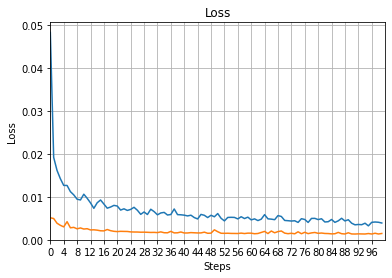

In [26]:
plot_loss(history.history['loss'], history.history['val_loss'], 'Loss', y_max, 100) 
#loss seems on point 

In [27]:
model.evaluate(X_test, Y_test)

3/3 [==============================] - 0s 6ms/step - loss: 0.0015 - last_time_step_mse: 0.0013


[0.001472765696235001, 0.0013349557993933558]

In [28]:
len(data)

477

In [41]:
X_new, Y_new = data[:425], data[425:]
X_new, Y_new = features(X_new, 20)
X_new = X_new.reshape(X_new.shape[0], 1, X_new.shape[1])
Y_pred = model.predict(X_new)
Y_pred

13/13 [==============================] - 0s 3ms/step


array([[[0.19057943]],

       [[0.2140157 ]],

       [[0.23417014]],

       [[0.2489576 ]],

       [[0.2555557 ]],

       [[0.26472768]],

       [[0.26114905]],

       [[0.2644036 ]],

       [[0.27148575]],

       [[0.2991373 ]],

       [[0.31292197]],

       [[0.29772365]],

       [[0.30272144]],

       [[0.30528623]],

       [[0.31304947]],

       [[0.31033164]],

       [[0.31005526]],

       [[0.3226477 ]],

       [[0.35698533]],

       [[0.34743804]],

       [[0.33799243]],

       [[0.34617615]],

       [[0.3439911 ]],

       [[0.34480906]],

       [[0.34896335]],

       [[0.36630613]],

       [[0.38840595]],

       [[0.40377223]],

       [[0.41847843]],

       [[0.43909025]],

       [[0.48176986]],

       [[0.5383002 ]],

       [[0.52569574]],

       [[0.54528946]],

       [[0.569403  ]],

       [[0.55864966]],

       [[0.53902495]],

       [[0.55064476]],

       [[0.5477138 ]],

       [[0.5518295 ]],

       [[0.5491944 ]],

       [[0.56698

In [49]:
Y_pred = Y_pred.reshape(Y_pred.shape[0], Y_pred.shape[1])

In [50]:
mse = mean_squared_error(Y_new, Y_pred)

print("Mean squared error:", mse)

Mean squared error: 0.002151094


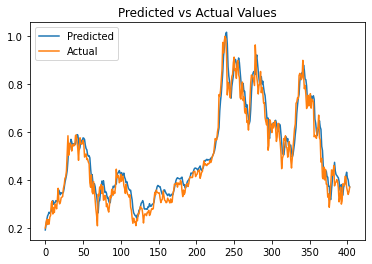

In [53]:
import matplotlib.pyplot as plt

#Plot predicted values
plt.plot(Y_pred, label='Predicted')

# Plot actual values
plt.plot(Y_new, label='Actual')

# Add title and legend
plt.title('Predicted vs Actual Values')
plt.legend()